In [3]:
import tensorflow as tf
import pandas as pd
import numpy as np
import os

In [4]:
path = os.path.join("jigsaw-toxic-comment-classification-challenge","train.csv","train.csv")

In [5]:
df = pd.read_csv(path)

In [8]:
path

'jigsaw-toxic-comment-classification-challenge/train.csv/train.csv'

In [7]:
df.head(3)

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0


In [9]:
# example comment
df.iloc[0].comment_text

"Explanation\nWhy the edits made under my username Hardcore Metallica Fan were reverted? They weren't vandalisms, just closure on some GAs after I voted at New York Dolls FAC. And please don't remove the template from the talk page since I'm retired now.89.205.38.27"

In [11]:
df[df.columns[2:]].iloc[6]

toxic            1
severe_toxic     1
obscene          1
threat           0
insult           1
identity_hate    0
Name: 6, dtype: int64

# Preprocessing
1. Tokenization : map each word in the sentence to a number
2. Create the data input pipeline : create the dataset : map,cache,shuffle,batch and prefetch
3. Try to grab a batch using (dataset.as_numpy_iterator().next())
4. Create training, validation and testing splits

In [14]:
from tensorflow.keras.layers import TextVectorization # maps text features to integer sequences

In [16]:
X = df['comment_text']
y = df[df.columns[2:]].values

In [22]:
MAX_FEATURES = 200000 # how many words are there in the vocabulary
# number of words in the vocabulary

In [23]:
vectorizer = TextVectorization(max_tokens=MAX_FEATURES, output_mode='int',output_sequence_length=1800)

In [39]:
# teach the vectorizer the vocabulary
vectorizer.adapt(X.values)

In [28]:
vectorizer.get_vocabulary() # get the word mappings

['',
 '[UNK]',
 'the',
 'to',
 'of',
 'and',
 'a',
 'you',
 'i',
 'is',
 'that',
 'in',
 'it',
 'for',
 'this',
 'not',
 'on',
 'be',
 'as',
 'have',
 'are',
 'your',
 'with',
 'if',
 'article',
 'was',
 'or',
 'but',
 'page',
 'my',
 'an',
 'from',
 'by',
 'do',
 'at',
 'about',
 'me',
 'so',
 'wikipedia',
 'can',
 'what',
 'there',
 'all',
 'has',
 'will',
 'talk',
 'please',
 'would',
 'its',
 'no',
 'one',
 'just',
 'like',
 'they',
 'he',
 'dont',
 'which',
 'any',
 'been',
 'should',
 'more',
 'we',
 'some',
 'other',
 'who',
 'see',
 'here',
 'also',
 'his',
 'think',
 'im',
 'because',
 'know',
 'how',
 'am',
 'people',
 'why',
 'edit',
 'articles',
 'only',
 'out',
 'up',
 'when',
 'were',
 'use',
 'then',
 'may',
 'time',
 'did',
 'them',
 'now',
 'being',
 'their',
 'than',
 'thanks',
 'even',
 'get',
 'make',
 'good',
 'had',
 'very',
 'information',
 'does',
 'could',
 'well',
 'want',
 'such',
 'sources',
 'way',
 'name',
 'these',
 'deletion',
 'pages',
 'first',
 'help'

In [30]:
sample =vectorizer("Hi, how are you doing?")

In [32]:
sample.shape

TensorShape([1800])

In [40]:
# get the vectorized text
vectorized_text = vectorizer(X.values)

In [41]:
vectorized_text

<tf.Tensor: shape=(159571, 1800), dtype=int64, numpy=
array([[  645,    76,     2, ...,     0,     0,     0],
       [    1,    54,  2489, ...,     0,     0,     0],
       [  425,   441,    70, ...,     0,     0,     0],
       ...,
       [32445,  7392,   383, ...,     0,     0,     0],
       [    5,    12,   534, ...,     0,     0,     0],
       [    5,     8,   130, ...,     0,     0,     0]])>

In [43]:
len(vectorized_text) # no of samples in training data

159571

In [46]:
# creating an input dataset pipeline
#MCSHBAP : map, cache, shuffle, batch, prefetch --> data pipeline procedure
dataset = tf.data.Dataset.from_tensor_slices((vectorized_text,y))
dataset = dataset.cache()
dataset = dataset.shuffle(160000)
dataset = dataset.batch(16)
dataset = dataset.prefetch(8)

In [50]:
dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 1800), dtype=tf.int64, name=None), TensorSpec(shape=(None, 6), dtype=tf.int64, name=None))>

In [60]:
batch_X, batch_y = dataset.as_numpy_iterator().next() # get first batch of 16 samples

In [64]:
print(f"length of batch : {len(batch_X)}" )
print(f"length of each sample : {len(batch_X[0])}" )


length of batch : 16
length of each sample : 1800


In [67]:
# partitioning the data into train, validation and test sets
train = dataset.take(int(len(dataset)*0.7))
val = dataset.take(int(len(dataset)*0.7)).take(int(len(dataset)*0.2))
test = dataset.take(int(len(dataset)*0.9)).take(int(len(dataset)*0.1))

In [70]:
print(f"length of train dataset is {len(train)} batches")
print(f"length of validation dataset is {len(val)} batches")
print(f"length of test dataset is {len(test)} batches")

length of train dataset is 6981 batches
length of validation dataset is 1994 batches
length of test dataset is 997 batches


# Building the model

In [74]:
from tensorflow.keras.layers import Dense,LSTM, Dropout,Bidirectional,Embedding
from tensorflow.keras.models import Sequential

In [83]:
model = Sequential()
#create the embedding layer
model.add(Embedding(MAX_FEATURES+1,32))  # +1 for the unkown words, and 32 words per embeddings

# create the LSTM layer : tanh activation
model.add(Bidirectional(LSTM(32,activation='tanh')))  # bidirectional helps a lot for sentences

# A bunch of dense layers (fully connected layers)
model.add(Dense(128,activation = 'relu'))
model.add(Dense(256,activation = 'relu'))
model.add(Dense(128,activation = 'relu'))

# the output layer
model.add(Dense(6,activation = 'sigmoid'))

In [82]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, None, 32)          6400032   
                                                                 
 bidirectional_4 (Bidirecti  (None, 64)                16640     
 onal)                                                           
                                                                 
 dense_9 (Dense)             (None, 128)               8320      
                                                                 
 dense_10 (Dense)            (None, 256)               33024     
                                                                 
 dense_11 (Dense)            (None, 128)               32896     
                                                                 
 dense_12 (Dense)            (None, 6)                 774       
                                                      

In [84]:
model.compile(loss = 'BinaryCrossentropy',optimizer='Adam')

In [85]:
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_5 (Embedding)     (None, None, 32)          6400032   
                                                                 
 bidirectional_5 (Bidirecti  (None, 64)                16640     
 onal)                                                           
                                                                 
 dense_13 (Dense)            (None, 128)               8320      
                                                                 
 dense_14 (Dense)            (None, 256)               33024     
                                                                 
 dense_15 (Dense)            (None, 128)               32896     
                                                                 
 dense_16 (Dense)            (None, 6)                 774       
                                                      

In [86]:
tf.__version__

'2.14.0'

In [88]:
# training the mode
history = model.fit(train,epochs=1,validation_data=val)

6981/6981 [==============================] - 9005s 1s/step - loss: 0.0600 - val_loss: 0.0454


In [89]:
import matplotlib.pyplot as plt

In [91]:
history.history

{'loss': [0.059995926916599274], 'val_loss': [0.04544752836227417]}

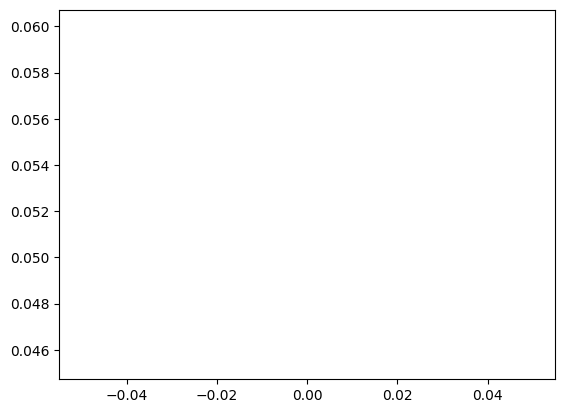

In [93]:
# create a dataset of history
history_df = pd.DataFrame(history.history)
plt.plot(history_df)

## Making Predictions

In [108]:
sample_text = "You freaking suck! and I hate you"
# vectorize the text
sample_text_vectorized = vectorizer(sample_text)[:5]


In [109]:
res = model.predict(np.expand_dims(sample_text_vectorized,axis=0)) # pass it as a sequence

1/1 [==============================] - 0s 11ms/step


In [110]:
np.argmax(res)

0

In [111]:
res

array([[0.99524933, 0.22831367, 0.9376986 , 0.04406899, 0.8414757 ,
        0.23552833]], dtype=float32)

In [112]:
# predicting a batch
batch_X,batch_y = test.as_numpy_iterator().next()

In [118]:
res = (model.predict(batch_X) > 0.5).astype(int)

1/1 [==============================] - 0s 45ms/step


In [120]:
res

array([[0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0]])

In [121]:
batch_y

array([[0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0]])

# Evaluating the model

In [123]:
from tensorflow.keras.metrics import Precision,Recall,CategoricalAccuracy

In [124]:
pre = Precision()
re = Recall()
acc = CategoricalAccuracy()